In [2]:
# Importar bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Carregar os arquivos necessários
admissions_df = pd.read_csv("admissions.csv")
icustays_df = pd.read_csv("icustays.csv")
patients_df = pd.read_csv("patients.csv")
diagnoses_df = pd.read_csv("diagnoses_icd.csv")  # Diagnósticos dos pacientes
icd_descriptions_df = pd.read_csv("d_icd_diagnoses.csv")  # Descrição dos diagnósticos

# 📌 Converter colunas de tempo para datetime
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])
icustays_df['intime'] = pd.to_datetime(icustays_df['intime'])
icustays_df['outtime'] = pd.to_datetime(icustays_df['outtime'])

# 📌 Calcular tempo de internação
admissions_df['hospital_los'] = (admissions_df['dischtime'] - admissions_df['admittime']).dt.total_seconds() / (24 * 3600)
icustays_df['icu_los'] = (icustays_df['outtime'] - icustays_df['intime']).dt.total_seconds() / (24 * 3600)

# 📌 Filtrar apenas os pacientes que foram para a UTI
pacientes_uti = admissions_df.merge(icustays_df[['subject_id', 'stay_id', 'icu_los']], on="subject_id", how="inner")

# 📌 Unir dados da UTI com a informação de mortalidade
mortalidade_uti = pacientes_uti[['subject_id', 'hospital_expire_flag', 'icu_los']]
mortalidade_uti_corrigida = pacientes_uti[['subject_id', 'hospital_expire_flag']].drop_duplicates()

# 📌 Estatísticas gerais
total_pacientes_uti = pacientes_uti['subject_id'].nunique()
num_obitos_uti = mortalidade_uti_corrigida[mortalidade_uti_corrigida['hospital_expire_flag'] == 1]['subject_id'].nunique()
num_sobreviventes_uti = total_pacientes_uti - num_obitos_uti
taxa_mortalidade_uti = (num_obitos_uti / total_pacientes_uti) * 100
tempo_medio_uti = icustays_df['icu_los'].mean()

# 📌 Distribuição de Gênero (Corrigida para exibição correta)
genero_contagem = patients_df['gender'].value_counts().to_dict()

# 📌 Exibir estatísticas no terminal
print("\n📊 Estatísticas Gerais dos Pacientes na UTI:")
print(f"• Total de Pacientes na UTI: {total_pacientes_uti}")
print(f"• Pacientes que sobreviveram: {num_sobreviventes_uti}")
print(f"• Pacientes que faleceram na UTI: {num_obitos_uti}")
print(f"• Taxa de Mortalidade na UTI: {taxa_mortalidade_uti:.2f}%")
print(f"• Tempo médio de internação na UTI: {tempo_medio_uti:.2f} dias\n")

print("📊 Distribuição de Gênero:")
for genero, contagem in genero_contagem.items():
    print(f"• {genero}: {contagem} pacientes")
    
# 📌 Filtrar apenas os diagnósticos dos pacientes que foram para a UTI
diagnoses_uti = diagnoses_df.merge(pacientes_uti[['subject_id']], on="subject_id", how="inner")

# 📌 Contar o número de pacientes únicos para cada diagnóstico na UTI
diagnosticos_uti_corrigido = diagnoses_uti.groupby("icd_code")["subject_id"].nunique().reset_index()
diagnosticos_uti_corrigido.columns = ["Código ICD", "Número de Pacientes"]

# 📌 Unir com as descrições dos diagnósticos
diagnosticos_uti_corrigido = diagnosticos_uti_corrigido.merge(
    icd_descriptions_df[['icd_code', 'long_title']], left_on="Código ICD", right_on="icd_code", how="left"
).drop(columns=["icd_code"])  # Remover duplicata da coluna ICD

# 📌 Renomear coluna de descrição do diagnóstico
diagnosticos_uti_corrigido = diagnosticos_uti_corrigido.rename(columns={"long_title": "Descrição do Diagnóstico"})

# 📌 Ordenar pelos diagnósticos mais frequentes
diagnosticos_uti_corrigido = diagnosticos_uti_corrigido.sort_values(by="Número de Pacientes", ascending=False).head(10)
diagnosticos_uti_corrigido = diagnosticos_uti_corrigido.reset_index(drop=True)

# 📌 Exibir os resultados corrigidos
from IPython.display import display

print("\n📊 Top 10 Diagnósticos Mais Frequentes na UTI (Número de Pacientes Únicos)\n")
display(diagnosticos_uti_corrigido)

# 📌 Salvar a tabela para uso futuro
diagnosticos_uti_corrigido.to_csv("diagnosticos_uti.csv", index=False)


📊 Estatísticas Gerais dos Pacientes na UTI:
• Total de Pacientes na UTI: 100
• Pacientes que sobreviveram: 85
• Pacientes que faleceram na UTI: 15
• Taxa de Mortalidade na UTI: 15.00%
• Tempo médio de internação na UTI: 3.68 dias

📊 Distribuição de Gênero:
• M: 57 pacientes
• F: 43 pacientes

📊 Top 10 Diagnósticos Mais Frequentes na UTI (Número de Pacientes Únicos)



,Código ICD,Número de Pacientes,Descrição do Diagnóstico
0,4019,41,Unspecified essential hypertension
1,2724,34,Other and unspecified hyperlipidemia
2,E785,21,"Hyperlipidemia, unspecified"
3,25000,21,Diabetes mellitus without mention of complicat...
4,V1582,20,Personal history of tobacco use
5,41401,19,Coronary atherosclerosis of native coronary ar...
6,3051,18,Tobacco use disorder
7,2859,18,"Anemia, unspecified"
8,42731,18,Atrial fibrillation
9,I10,17,Essential (primary) hypertension


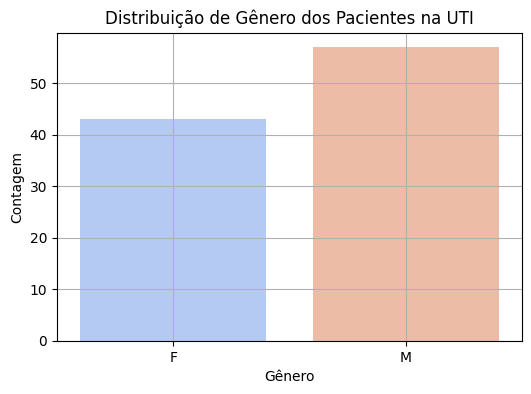

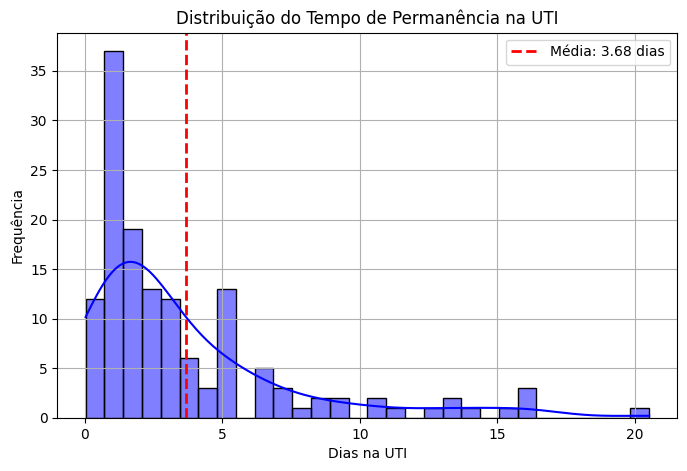

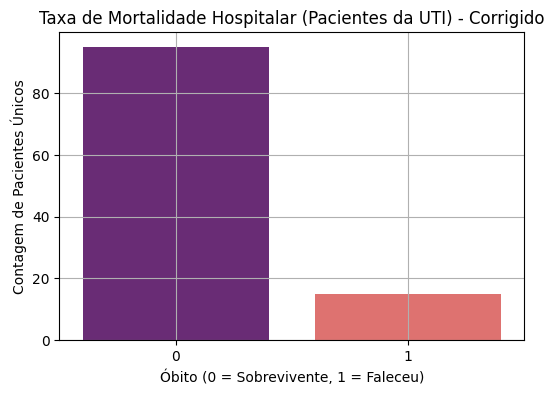

In [3]:
# 📊 Distribuição de Gênero
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=patients_df, hue='gender', palette="coolwarm", legend=False)
plt.xlabel("Gênero")
plt.ylabel("Contagem")
plt.title("Distribuição de Gênero dos Pacientes na UTI")
plt.grid(True)
plt.savefig("distribuicao_genero_uti.png", dpi=300)
plt.show()

# 📊 **Melhoria: Distribuição do Tempo Médio de Internação na UTI com Linha de Média**
plt.figure(figsize=(8, 5))
sns.histplot(icustays_df['icu_los'].dropna(), bins=30, kde=True, color="blue")
plt.axvline(tempo_medio_uti, color='red', linestyle='dashed', linewidth=2, label=f'Média: {tempo_medio_uti:.2f} dias')
plt.xlabel("Dias na UTI")
plt.ylabel("Frequência")
plt.title("Distribuição do Tempo de Permanência na UTI")
plt.legend()
plt.grid(True)
plt.savefig("tempo_medio_internacao_uti.png", dpi=300)
plt.show()

# 📊 **Taxa de Mortalidade Hospitalar (Apenas Pacientes da UTI) - Corrigido**
plt.figure(figsize=(6, 4))
sns.countplot(x='hospital_expire_flag', data=mortalidade_uti_corrigida, hue='hospital_expire_flag', palette="magma", legend=False)
plt.xlabel("Óbito (0 = Sobrevivente, 1 = Faleceu)")
plt.ylabel("Contagem de Pacientes Únicos")
plt.title("Taxa de Mortalidade Hospitalar (Pacientes da UTI) - Corrigido")
plt.grid(True)
plt.savefig("mortalidade_uti.png", dpi=300)
plt.show()


📊 **Comparação de Mortalidade entre Pacientes que Usaram e Não Usaram Vasopressores**

            Grupo  Número de Pacientes  Óbitos  Taxa de Mortalidade (%)
Com Vasopressores                   53      12                22.641509
Sem Vasopressores                   47       3                 6.382979


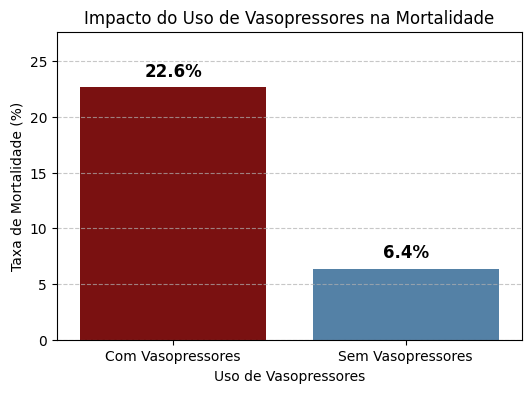


✅ **Análise Final: Impacto das Comorbidades no Uso de Vasopressores**

Código ICD  Número de Pacientes com Comorbidade  Pacientes com Vasopressores  % Pacientes com Vasopressores                                                                                   Descrição da Comorbidade
     42731                                   18                           12                      66.666667                                                                                        Atrial fibrillation
      2859                                   18                           12                      66.666667                                                                                        Anemia, unspecified
      E785                                   21                           14                      66.666667                                                                                Hyperlipidemia, unspecified
     41401                                   19                     

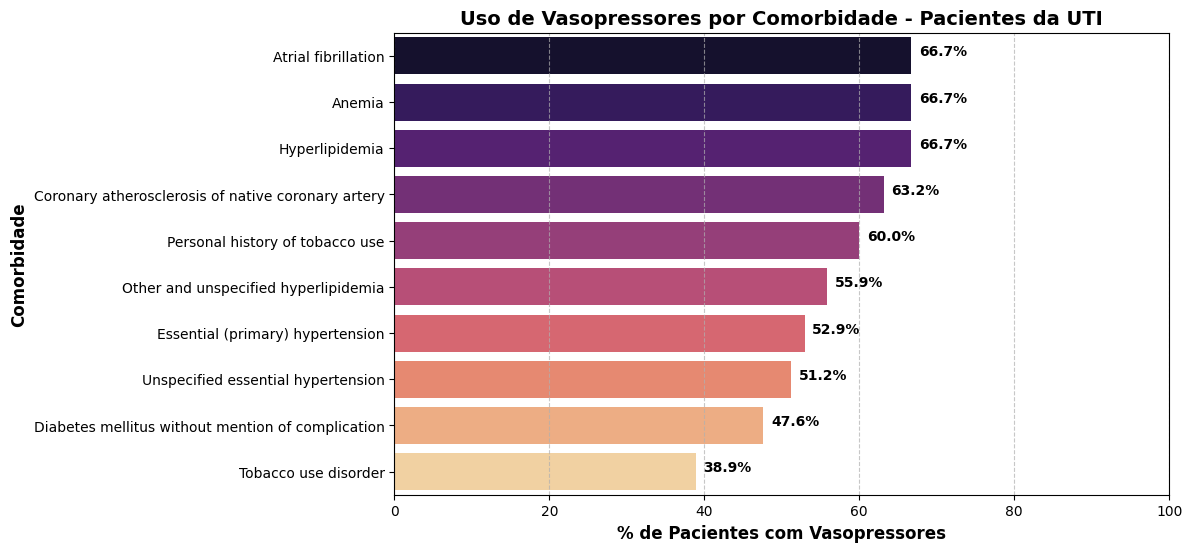

In [4]:
import seaborn as sns

# 📌 Carregar os dados
prescriptions_df = pd.read_csv("prescriptions.csv")

# 📌 Lista de Vasopressores de Interesse
vasopressores = ["dopamine", "epinephrine", "norepinephrine", "phenylephrine", "vasopressin"]

# 📌 Filtrar pacientes que receberam vasopressores
pacientes_vasopressores = prescriptions_df[prescriptions_df['drug'].str.contains('|'.join(vasopressores), case=False, na=False)]
num_pacientes_vasopressores = pacientes_vasopressores['subject_id'].nunique()

# 📌 Criar grupos de pacientes
pacientes_sem_vasopressores = pacientes_uti[~pacientes_uti["subject_id"].isin(pacientes_vasopressores["subject_id"])]
num_pacientes_sem_vasopressores = pacientes_sem_vasopressores['subject_id'].nunique()

# 📌 Contar óbitos nos dois grupos
num_obitos_vasopressores = pacientes_vasopressores.merge(
    pacientes_uti[['subject_id', 'hospital_expire_flag']], on="subject_id", how="left"
)
num_obitos_vasopressores = num_obitos_vasopressores[num_obitos_vasopressores['hospital_expire_flag'] == 1]['subject_id'].nunique()
num_obitos_sem_vasopressores = pacientes_sem_vasopressores[pacientes_sem_vasopressores['hospital_expire_flag'] == 1]['subject_id'].nunique()

# 📌 Calcular taxas de mortalidade
taxa_mortalidade_vasopressores = (num_obitos_vasopressores / num_pacientes_vasopressores) * 100
taxa_mortalidade_sem_vasopressores = (num_obitos_sem_vasopressores / num_pacientes_sem_vasopressores) * 100

# 📌 Criar DataFrame de comparação
tabela_mortalidade = pd.DataFrame({
    "Grupo": ["Com Vasopressores", "Sem Vasopressores"],
    "Número de Pacientes": [num_pacientes_vasopressores, num_pacientes_sem_vasopressores],
    "Óbitos": [num_obitos_vasopressores, num_obitos_sem_vasopressores],
    "Taxa de Mortalidade (%)": [taxa_mortalidade_vasopressores, taxa_mortalidade_sem_vasopressores]
})
print("\n📊 **Comparação de Mortalidade entre Pacientes que Usaram e Não Usaram Vasopressores**\n")
print(tabela_mortalidade.to_string(index=False))

# 📌 Criar gráfico de impacto dos vasopressores na mortalidade
plt.figure(figsize=(6, 4))
sns.barplot(x="Grupo", y="Taxa de Mortalidade (%)", hue="Grupo", data=tabela_mortalidade, palette=["darkred", "steelblue"], legend=False)
plt.ylabel("Taxa de Mortalidade (%)")
plt.xlabel("Uso de Vasopressores")
plt.title("Impacto do Uso de Vasopressores na Mortalidade")
plt.ylim(0, max(tabela_mortalidade["Taxa de Mortalidade (%)"]) + 5)
for i, row in tabela_mortalidade.iterrows():
    plt.text(i, row["Taxa de Mortalidade (%)"] + 1, f"{row['Taxa de Mortalidade (%)']:.1f}%", ha='center', fontsize=12, fontweight='bold')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("impacto_vasopressores_mortalidade.png", dpi=300)
plt.show()

# 📌 Análise de comorbidades
diagnoses_uti_filtrado = diagnoses_uti[diagnoses_uti["icd_code"].isin(["4019", "2724", "E785", "25000", "V1582", "41401", "3051", "2859", "42731", "I10"])]
uso_por_comorbidade = diagnoses_uti_filtrado.groupby("icd_code")["subject_id"].nunique().reset_index()
uso_por_comorbidade.columns = ["Código ICD", "Número de Pacientes com Comorbidade"]

uso_vasopressores_comorbidade = diagnoses_uti_filtrado.merge(
    pacientes_vasopressores[['subject_id']], on="subject_id", how="inner"
).groupby("icd_code")["subject_id"].nunique().reset_index()
uso_vasopressores_comorbidade.columns = ["Código ICD", "Pacientes com Vasopressores"]

impacto_comorbidade = uso_por_comorbidade.merge(uso_vasopressores_comorbidade, on="Código ICD", how="left")
impacto_comorbidade["Pacientes com Vasopressores"] = impacto_comorbidade["Pacientes com Vasopressores"].fillna(0)
impacto_comorbidade["% Pacientes com Vasopressores"] = (
    impacto_comorbidade["Pacientes com Vasopressores"] / impacto_comorbidade["Número de Pacientes com Comorbidade"]
) * 100

impacto_comorbidade = impacto_comorbidade.merge(
    icd_descriptions_df[['icd_code', 'long_title']], left_on="Código ICD", right_on="icd_code", how="left"
).drop(columns=["icd_code"])
impacto_comorbidade.rename(columns={"long_title": "Descrição da Comorbidade"}, inplace=True)
impacto_comorbidade.sort_values(by="% Pacientes com Vasopressores", ascending=False, inplace=True)

print("\n✅ **Análise Final: Impacto das Comorbidades no Uso de Vasopressores**\n")
print(impacto_comorbidade.to_string(index=False))
impacto_comorbidade.to_csv("impacto_vasopressores_comorbidades.csv", index=False)

# 📊 **Criar Gráfico de Uso de Vasopressores por Comorbidade**
plt.figure(figsize=(10, 6))
sns.barplot(
    x=impacto_comorbidade["% Pacientes com Vasopressores"],
    y=impacto_comorbidade["Descrição da Comorbidade"].str.split(',').str[0],  # Reduzindo nomes longos
    hue=impacto_comorbidade["Descrição da Comorbidade"],  # Atribuir hue
    palette="magma",
    legend=False  # Remover legenda duplicada
)

# 📌 Melhorar a formatação do gráfico
plt.xlabel("% de Pacientes com Vasopressores", fontsize=12, fontweight='bold')
plt.ylabel("Comorbidade", fontsize=12, fontweight='bold')
plt.title("Uso de Vasopressores por Comorbidade - Pacientes da UTI", fontsize=14, fontweight='bold')
plt.xlim(0, 100)  # O limite máximo é 100%
plt.grid(axis="x", linestyle="--", alpha=0.7)

# 📌 Adicionar valores no topo das barras
for i, row in enumerate(impacto_comorbidade["% Pacientes com Vasopressores"]):
    plt.text(row + 1, i, f"{row:.1f}%", ha="left", fontsize=10, fontweight="bold", color="black")

# 📌 Salvar e mostrar o gráfico aprimorado
plt.savefig("uso_vasopressores_por_comorbidade.png", dpi=300)
plt.show()



1️⃣ Importação de Bibliotecas
📌 Carregue todas as bibliotecas necessárias.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


📊 **Comparação de Mortalidade entre Pacientes com e sem Ventilação Mecânica**

                  Grupo  Número de Pacientes  Óbitos  Taxa de Mortalidade (%)
Com Ventilação Mecânica                   55      13                23.636364
Sem Ventilação Mecânica                   45       2                 4.444444


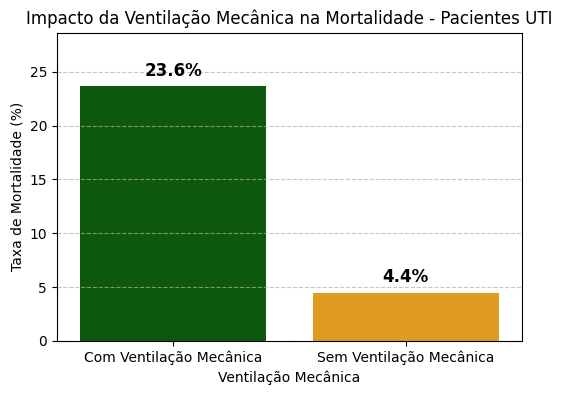

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Carregar dados
procedureevents_df = pd.read_csv("procedureevents.csv")
pacientes_uti = pd.read_csv("admissions.csv")

# 📌 Filtrar procedimentos de ventilação mecânica
ventilacao_df = procedureevents_df[procedureevents_df['ordercategoryname'].str.contains("Ventilation", case=False, na=False)]
pacientes_ventilacao = ventilacao_df[['subject_id']].drop_duplicates()
pacientes_ventilacao['ventilacao'] = 1

# 📌 Criar coluna de ventilação no admissions
pacientes_uti = pacientes_uti.merge(pacientes_ventilacao, on='subject_id', how='left')
pacientes_uti['ventilacao'] = pacientes_uti['ventilacao'].fillna(0)

# 📌 Separar os dois grupos
grupo_com_ventilacao = pacientes_uti[pacientes_uti['ventilacao'] == 1]
grupo_sem_ventilacao = pacientes_uti[pacientes_uti['ventilacao'] == 0]

# 📌 Contar óbitos nos dois grupos
num_pacientes_ventilacao = grupo_com_ventilacao['subject_id'].nunique()
num_obitos_ventilacao = grupo_com_ventilacao[grupo_com_ventilacao['hospital_expire_flag'] == 1]['subject_id'].nunique()

num_pacientes_sem_ventilacao = grupo_sem_ventilacao['subject_id'].nunique()
num_obitos_sem_ventilacao = grupo_sem_ventilacao[grupo_sem_ventilacao['hospital_expire_flag'] == 1]['subject_id'].nunique()

# 📌 Calcular taxas de mortalidade
taxa_mortalidade_ventilacao = (num_obitos_ventilacao / num_pacientes_ventilacao) * 100
taxa_mortalidade_sem_ventilacao = (num_obitos_sem_ventilacao / num_pacientes_sem_ventilacao) * 100

# 📌 Criar DataFrame de comparação
tabela_mortalidade_ventilacao = pd.DataFrame({
    "Grupo": ["Com Ventilação Mecânica", "Sem Ventilação Mecânica"],
    "Número de Pacientes": [num_pacientes_ventilacao, num_pacientes_sem_ventilacao],
    "Óbitos": [num_obitos_ventilacao, num_obitos_sem_ventilacao],
    "Taxa de Mortalidade (%)": [taxa_mortalidade_ventilacao, taxa_mortalidade_sem_ventilacao]
})

print("\n📊 **Comparação de Mortalidade entre Pacientes com e sem Ventilação Mecânica**\n")
print(tabela_mortalidade_ventilacao.to_string(index=False))

# 📌 Criar gráfico
plt.figure(figsize=(6, 4))
sns.barplot(x="Grupo", y="Taxa de Mortalidade (%)", hue="Grupo", data=tabela_mortalidade_ventilacao, palette=["darkgreen", "orange"], legend=False)
plt.ylabel("Taxa de Mortalidade (%)")
plt.xlabel("Ventilação Mecânica")
plt.title("Impacto da Ventilação Mecânica na Mortalidade - Pacientes UTI")
plt.ylim(0, max(tabela_mortalidade_ventilacao["Taxa de Mortalidade (%)"]) + 5)
for i, row in tabela_mortalidade_ventilacao.iterrows():
    plt.text(i, row["Taxa de Mortalidade (%)"] + 1, f"{row['Taxa de Mortalidade (%)']:.1f}%", ha='center', fontsize=12, fontweight='bold')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("impacto_ventilacao_mortalidade.png", dpi=300)
plt.show()

